# 示例代码

首先是一个shapefile有多个polygon组成，每个polygon代表一个流域，拆分成多个shapefile。

examples_data/bas_nonref_CntlPlains.shp
<class 'geopandas.geodataframe.GeoDataFrame'>
           AREA  PERIMETER   GAGE_ID  \
0  1.209580e+08    81060.0  03144816   
1  3.458990e+08   158340.0  03145000   
2  2.573460e+07    38760.0  03156000   
3  2.288740e+08   115800.0  03157000   
4  1.194710e+09   290820.0  03157500   

                                            geometry  
0  POLYGON ((1123005.000 1972005.000, 1123035.000...  
1  POLYGON ((1123005.000 1972005.000, 1123035.000...  
2  POLYGON ((1130325.000 1933275.000, 1130325.000...  
3  POLYGON ((1123755.000 1919955.000, 1123725.000...  
4  POLYGON ((1123755.000 1919955.000, 1123725.000...  
Index(['AREA', 'PERIMETER', 'GAGE_ID', 'geometry'], dtype='object')


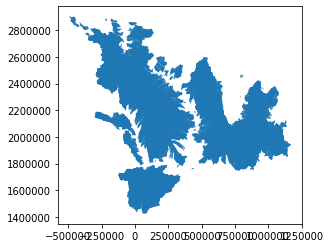

In [1]:
import os
import geopandas as gpd

# Define path to folder，以r开头表示相对路径
input_folder = r"examples_data"

# Join folder path and filename
fp = os.path.join(input_folder, "bas_nonref_CntlPlains.shp")

# Print out the full file path
print(fp)

# Read file using gpd.read_file()
data = gpd.read_file(fp)

print(type(data))
# 注意观察，geometry是一个由一系列坐标点组成的list，放入polygon的
print(data.head())
print(data.columns)

%matplotlib inline
data.plot()

先做坐标转换，首先看看现有数据的坐标系是什么，从上面的数据可以看出，坐标应该是m的形式，肯定是个投影坐标系。

In [20]:
from pyproj import CRS
print(data.crs)
crs_proj4 = CRS(data.crs).to_proj4()
print(crs_proj4)

{'init': 'epsg:5070'}
+proj=aea +lat_0=23 +lon_0=-96 +lat_1=29.5 +lat_2=45.5 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +type=crs


epsg:5070代表什么呢？在[epsg网站](https://epsg.io/)上查询，或直接谷歌或百度搜索。经查，在 https://epsg.io/5070-1252 网页上有说明，那现在想把它转为什么坐标呢，想转为下面要用的netcdf数据的坐标，因此这里暂停下，去下面看看netcdf数据的读取。然后查看下netcdf数据的坐标信息，这里先用一个[nad83下的Lambert等角圆锥投影](https://epsg.io/102009)到一个[wgs84下的横轴墨卡托投影](https://epsg.io/41001)的坐标变换做例子，为了验证是否正确，在https://epsg.io/ 网站上转一个点，然后和这里对照。

![](trans_coord.png)

In [35]:
from pyproj import Transformer
from pyproj import Proj, transform

crs_from=CRS.from_proj4('+proj=lcc +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
crs_to=CRS.from_proj4('+proj=merc +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs')
print(crs_from)
print(crs_to)
# print(crs_to.to_epsg())
# 定义transformer
transformer = Transformer.from_crs(crs_from, crs_to, always_xy=True)
x_coord = 1427469.56401013
y_coord = 231871.42687957
x1,y1 = transformer.transform(x_coord, y_coord)  
print(x1)
print(y1)

#  接着转换x，y坐标为经纬度坐标 WGS84坐标
outProj = Proj(init='epsg:4326')
print(outProj)
x2,y2 = transform(crs_to,outProj,x1,y1)
print(x2)
print(y2)

+proj=lcc +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +type=crs
+proj=merc +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs
-8667612.35367563
4954170.578414323
Proj('+proj=longlat +datum=WGS84 +no_defs', preserve_units=True)
-77.86248654129997
40.794609791599655


![](trans_coord1.png)

下面例子中netcdf数据的坐标proj4信息是：+proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs

因此，将shapefile文件的坐标转换到该坐标下即可继续后面的运算。先尝试下转换到该坐标系下的情况，然后再转到WGS84下看看对错。坐标是一样的，应该是对的

In [40]:
crs_final=CRS.from_proj4('+proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs')
print(crs_final)
# 这应该是自定义的一种投影，没有epsg编号
print(crs_final.to_epsg())
transformer1 = Transformer.from_crs(crs_from, crs_final, always_xy=True)
x3,y3 = transformer1.transform(x_coord, y_coord)  
print(x3)
print(y3)
x4,y4 = transform(crs_final,outProj,x3,y3)
print(x4)
print(y4)

+proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs
None
1762267.535784329
54546.4057676215
-77.86248654129997
40.79460979159966


接下来就构建一个shapefile到shapefile的代码，首先读取shapefile，然后对每个polygon的每个坐标点进行坐标变换，然后再重新构建一个个的shapefile，以备后用。

然后再将shapefile分割成多个，在实际运行中可以不必写入shapefile，只是构建为独立的geodataframe。

In [4]:
from pyproj import CRS
# 索引和dataframe一致
print(data.iloc[0,:])
print(type(data.iloc[0,:]['geometry']))
print(list(data.iloc[0,:]['geometry'].exterior.coords)[0:5])
newdata = gpd.GeoDataFrame()
# 要赋值到0位置上，否则就成为geoseries了
newdata.at[0, 'geometry']  = data.iloc[0,:]['geometry']
print(type(newdata.at[0, 'geometry'] ))
newdata.at[0, 'AREA'] = data.iloc[0,:]['AREA']
newdata.at[0, 'PERIMETER'] = data.iloc[0,:]['PERIMETER']
newdata.at[0, 'GAGE_ID'] = data.iloc[0,:]['GAGE_ID']
print(newdata)
# Set the GeoDataFrame's coordinate system to WGS84 (i.e. epsg code 4326)
newdata.crs = CRS.from_epsg(4326).to_wkt()
print("\nWell-Known Text (WKT):\n",newdata.crs)
# def wirte_shpfile(selection):
#     #  每行直接索引出来的就不是Geodataframe数据了，所以要    
#     newdata = gpd.GeoDataFrame()
#     newdata['geometry'] = selection['geometry']
    
#     series.plot()
#     # Create a output path for the data
#     output_folder = r"L2_data/"
#     output_fp = os.path.join(output_folder, "Class_36200.shp")
#     # Write those rows into a new file (the default output file format is Shapefile)
#     selection.to_file(output_fp)
    
# shp_files = df.iloc[5,:].apply(wirte_shpfile, axis=1)

AREA                                               1.20958e+08
PERIMETER                                                81060
GAGE_ID                                               03144816
geometry     POLYGON ((1123005 1972005, 1123035 1972005, 11...
Name: 0, dtype: object
<class 'shapely.geometry.polygon.Polygon'>
[(1123005.0, 1972005.0), (1123035.0, 1972005.0), (1123065.0, 1972005.0), (1123065.0, 1971975.0), (1123095.0, 1971975.0)]
<class 'shapely.geometry.polygon.Polygon'>
                                            geometry         AREA  PERIMETER  \
0  POLYGON ((1123005 1972005, 1123035 1972005, 11...  120958000.0    81060.0   

    GAGE_ID  
0  03144816  

Well-Known Text (WKT):
 GEOGCRS["WGS 84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,2],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitu

然后是读取netcdf文件的栅格数据。首先需要获取netcdf数据，这里采用的例子是daymet。